In [1]:
#Import necessary packages:
import rasterio as rio 
import xarray as xr
import rio_cogeo.cogeo
from pyproj import Proj
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
from matplotlib.ticker import FormatStrFormatter
import cartopy.feature as cfeature

In [25]:
#Inspect source NetCDF files:
file = 'raw-data/GOES16/GOES16_test_data.nc'

ds = xr.open_dataset(file)

In [26]:
ds

<xarray.Dataset> Size: 120MB
Dimensions:                                           (y: 3000, x: 5000,
                                                       number_of_time_bounds: 2,
                                                       number_of_image_bounds: 2,
                                                       band: 1,
                                                       number_of_harmonization_coefficients: 3,
                                                       num_star_looks: 24)
Coordinates:
    t                                                 datetime64[ns] 8B ...
  * y                                                 (y) float32 12kB 0.1282...
  * x                                                 (x) float32 20kB -0.101...
    y_image                                           float32 4B ...
    x_image                                           float32 4B ...
    band_id                                           (band) int8 1B ...
    band_wavelength                                   (band) float32 4B ...
    t_star_look                                       (num_star_looks) datetime64[ns] 192B ...
    band_wavelength_star_look                         (num_star_looks) float32 96B ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                band, number_of_harmonization_coefficients,
                                num_star_looks
Data variables: (12/39)
    Rad                                               (y, x) float32 60MB ...
    DQF                                               (y, x) float32 60MB ...
    time_bounds                                       (number_of_time_bounds) datetime64[ns] 16B ...
    goes_imager_projection                            int32 4B ...
    y_image_bounds                                    (number_of_image_bounds) float32 8B ...
    x_image_bounds                                    (number_of_image_bounds) float32 8B ...
    ...                                                ...
    algorithm_dynamic_input_data_container            int32 4B ...
    processing_parm_version_container                 int32 4B ...
    algorithm_product_version_container               int32 4B ...
    star_id                                           (num_star_looks) float32 96B ...
    channel_integration_time                          float64 8B ...
    channel_gain_field                                float64 8B ...
Attributes: (12/30)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    production_site:           WCDAS
    ...                        ...
    timeline_id:               ABI Mode 6
    date_created:              2024-06-28T00:03:59.8Z
    time_coverage_start:       2024-06-28T00:01:17.5Z
    time_coverage_end:         2024-06-28T00:03:54.8Z
    LUT_Filenames:             SpaceLookParams(FM1A_CDRL79RevH_DO_13_00_00)-7...
    id:                        40efdaea-69ef-41d6-a2dc-c2bcc188f9f9

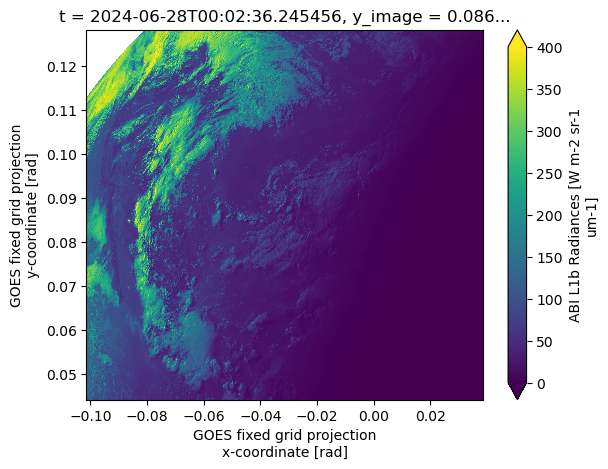

In [28]:
ds['Rad'].plot(vmin = 0, vmax = 400)

In [29]:
# Extract the projection information
proj_info_attrs = ds['goes_imager_projection'].attrs

# Extract the radiance data
rad = ds['Rad'].values

# Extract x and y coordinates
x = ds['x'].values
y = ds['y'].values

# Extract projection parameters from the metadata
lon_0 = proj_info_attrs['longitude_of_projection_origin']
h = proj_info_attrs['perspective_point_height']
r_eq = proj_info_attrs['semi_major_axis']
r_pol = proj_info_attrs['semi_minor_axis']

# GOES x/y are in radians, we need to scale them properly using the satellite height
# Convert x/y from radians to meters using satellite height
X, Y = np.meshgrid(x * h, y * h)

# Create a projection object using pyproj for geostationary projection
p = Proj(proj='geos', h=h, lon_0=lon_0, a=r_eq, b=r_pol, sweep=proj_info_attrs['sweep_angle_axis'])

# Convert the scaled x/y to lat/lon
lon, lat = p(X, Y, inverse=True)

# Mask invalid values (e.g., NaNs or infinities)
lon_masked = np.ma.masked_invalid(lon)
lat_masked = np.ma.masked_invalid(lat)
rad_masked = np.ma.masked_invalid(rad)

/srv/conda/envs/notebook/lib/python3.12/site-packages/cartopy/crs.py:421: RuntimeWarning: invalid value encountered in remainder
  x[to_180] = (((x[to_180] + 180) % 360) - 180)


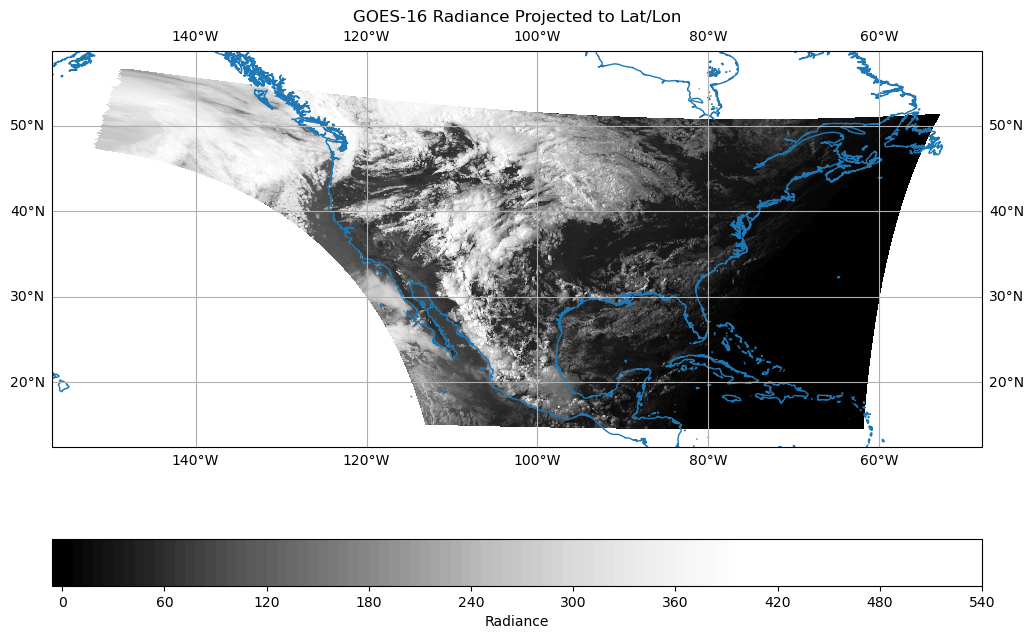

In [37]:
# Plot the Radiance data
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree()) 

contour = plt.contourf(lon_masked, lat_masked, rad_masked, levels=100, cmap='Greys_r', transform=ccrs.PlateCarree(), vmax = 400, vmin = 0)

plt.colorbar(contour, label='Radiance', orientation = 'horizontal')

# Add coastlines, borders, and gridlines for geographic context
ax.coastlines(resolution='10m', color='tab:blue', linewidth=1)
ax.gridlines(draw_labels=True)

# Set labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('GOES-16 Radiance Projected to Lat/Lon')

# Show the plot
plt.show()


In [31]:
import rioxarray
import xarray as xr
import numpy as np
import rasterio
from rasterio.enums import Resampling
import rio_cogeo.cogeo

# Assuming you already have lon, lat, and rad arrays from the previous steps

# Step 1: Convert the data into an xarray.DataArray
# Create a new DataArray for the radiance data, keeping x and y as dimensions
data_array = xr.DataArray(
    data=rad,  # The radiance data
    dims=["y", "x"],  # Define dimensions
    coords={
        "lon": (["y", "x"], lon),  # Longitude array as coordinates
        "lat": (["y", "x"], lat)   # Latitude array as coordinates
    },
    attrs={
        "long_name": "GOES-16 Radiance",
        "units": "Watts per square meter per steradian"
    }
)

# Step 2: Set the CRS and spatial dimensions using rioxarray
# Assign CRS (EPSG:4326 for lat/lon)
data_array = data_array.rio.write_crs("epsg:4326")

# Step 3: Write the data to a COG format
cog_filename = "test_cog_GOES.tif"
data_array.rio.to_raster(
    cog_filename,
    driver="COG",
    dtype="float32",  # Ensure the data type is appropriate
    compress="deflate",  # Add compression to reduce file size
)

/srv/conda/envs/notebook/lib/python3.12/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


In [32]:
# Step 4: Validate the COG file to ensure it's properly formatted
cog_valid = rio_cogeo.cogeo.cog_validate(cog_filename)
print(f"COG validation: {cog_valid}")

COG validation: (True, [], [])


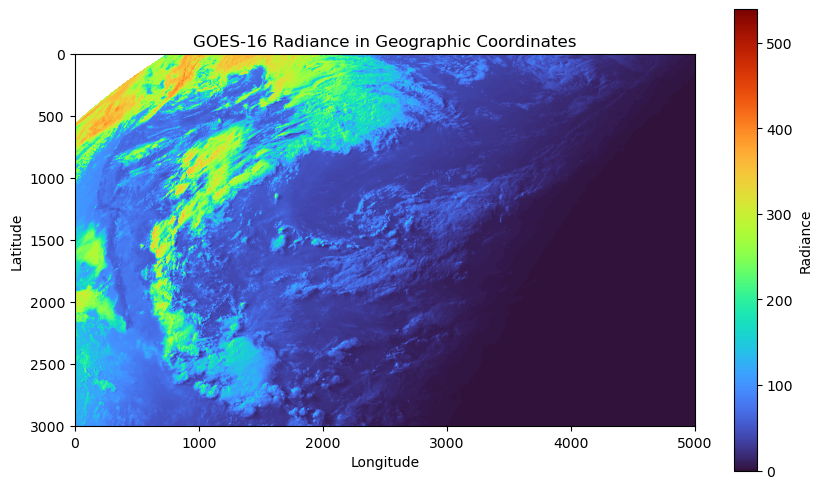

In [33]:
import rasterio
import matplotlib.pyplot as plt

# Path to the Cloud Optimized GeoTIFF (COG)
cog_filename = "test_cog_GOES.tif"

# Open the COG file using rasterio
with rasterio.open(cog_filename) as src:
    # Read the data from the COG
    data = src.read(1)  # Reading the first band (radiance data)
    
    # Get the bounds (left, bottom, right, top) of the dataset in geographic coordinates
    bounds = src.bounds
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]
    
    # Set up a figure
    plt.figure(figsize=(10, 6))
    
    # Plot the data using imshow and set the extent to geographic bounds
    plt.imshow(data, cmap='turbo', extent=extent, origin='upper')
    
    # Add labels and title
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('GOES-16 Radiance in Geographic Coordinates')

    # Add a colorbar
    plt.colorbar(label="Radiance")

    # Display the plot
    plt.show()